First, let's import all the necessary dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

Let's define some configuration variables.

In [2]:
DATASET = "s3://hedp/ecmwf-forecasts/opendata-oper-20231016T00.zarr"
LOCATION = {"latitude": 41.9, "longitude": 12.5}

In the following lines we:
- establish a connection with the remote dataset
- show its metadata

It is worth noticing that, in the first operation, only the information necessary to gather the dataset's metadata (e.g. its sizes, dimensions, variables' type and attributes) is actually downloaded from its remote location to the local machine.

In [3]:
ds = xr.open_dataset(DATASET, chunks={}, engine="zarr").astype("float32")
ds

<xarray.Dataset>
Dimensions:              (step: 65, latitude: 451, longitude: 900,
                          isobaricInhPa: 9)
Coordinates:
    depthBelowLandLayer  float64 ...
    entireAtmosphere     float64 ...
    heightAboveGround    float64 ...
  * isobaricInhPa        (isobaricInhPa) float64 1e+03 925.0 ... 200.0 50.0
  * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
  * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
  * step                 (step) timedelta64[ns] 00:00:00 ... 10 days 00:00:00
    surface              float64 ...
    time                 datetime64[ns] ...
    valid_time           (step) datetime64[ns] dask.array<chunksize=(65,), meta=np.ndarray>
Data variables: (12/16)
    10u                  (step, latitude, longitude) float32 dask.array<chunksize=(65, 41, 45), meta=np.ndarray>
    10v                  (step, latitude, longitude) float32 dask.array<chunksize=(65, 41, 45), meta=np.ndarray>
    2t                   (step, latitude, longitude) float32 dask.array<chunksize=(65, 41, 45), meta=np.ndarray>
    d                    (step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(65, 9, 41, 45), meta=np.ndarray>
    gh                   (step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(65, 9, 41, 45), meta=np.ndarray>
    q                    (step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(65, 9, 41, 45), meta=np.ndarray>
    ...                   ...
    t                    (step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(65, 9, 41, 45), meta=np.ndarray>
    tcwv                 (step, latitude, longitude) float32 dask.array<chunksize=(65, 41, 45), meta=np.ndarray>
    tp                   (step, latitude, longitude) float32 dask.array<chunksize=(65, 41, 45), meta=np.ndarray>
    u                    (step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(65, 9, 41, 45), meta=np.ndarray>
    v                    (step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(65, 9, 41, 45), meta=np.ndarray>
    vo                   (step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(65, 9, 41, 45), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2023-10-16T10:59 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Here we want to extract the 2-metre Temperature forecast, in Celsius, for a specific location.

Note that the operations prescribed in the following lines are actually performed, and the resulting data downloaded, only when the `.compute()` method is met. For this reason, as a general rule to maximize efficiency, the `compute()` method should be placed after an operation which significantly reduce the amount of data, such as after selection and reduction operations.

In [4]:
%%time

t2m = ds["2t"] - 273.15
t2m["step"] = t2m.step.astype('datetime64[ns]').astype('float64') / 1e9 / 3600
t2m.attrs["units"] = "C"
t2m_location = t2m.sel(**LOCATION, method="nearest")
t2m_location

CPU times: user 14 ms, sys: 529 µs, total: 14.5 ms
Wall time: 13.3 ms


<xarray.DataArray '2t' (step: 65)>
dask.array<getitem, shape=(65,), dtype=float32, chunksize=(65,), chunktype=numpy.ndarray>
Coordinates:
    depthBelowLandLayer  float64 ...
    entireAtmosphere     float64 ...
    heightAboveGround    float64 ...
    latitude             float64 42.0
    longitude            float64 12.4
    surface              float64 ...
    time                 datetime64[ns] ...
    valid_time           (step) datetime64[ns] dask.array<chunksize=(65,), meta=np.ndarray>
  * step                 (step) float64 0.0 3.0 6.0 9.0 ... 228.0 234.0 240.0
Attributes:
    units:    C

In [5]:
%%time
%%capture

t2m_location = t2m_location.compute()

CPU times: user 179 ms, sys: 36.9 ms, total: 216 ms
Wall time: 292 ms


Finally, let's plot the results on a time series.

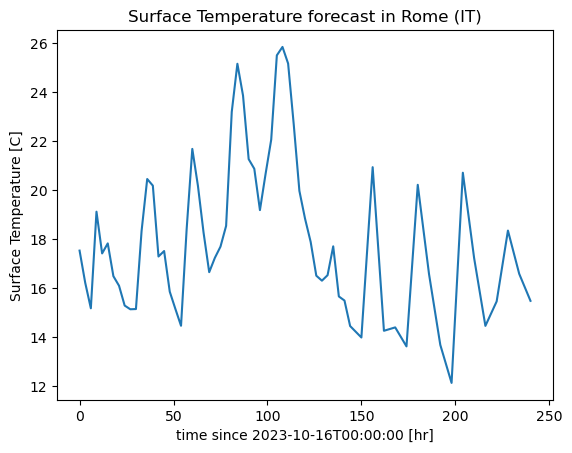

In [6]:
t2m_location.plot()
plt.title("Surface Temperature forecast in Rome (IT)")
plt.ylabel("Surface Temperature [C]")
reference_time = np.datetime_as_string(t2m_location.time.values)
plt.xlabel(f"time since {reference_time[:-10]} [hr]")
plt.show()